# Data augmentation

In [26]:
import os
from tensorflow.keras import preprocessing

# ImageDataGenerator 參數
# width_shift_range=[-3,3], #左右3%
# height_shift_range=[-3,3], #上下3%
# zoom_range=0.3

# input size(w,h)
w = 100
h = 100
# batch size
batchsize=128
# image directory
train_data_dir='./img_ok'
categories = os.listdir(train_data_dir)
datagen = preprocessing.image.ImageDataGenerator(
                             rescale=1. /255,
                             validation_split=0.2,
                             rotation_range=30 ,
                             shear_range=0.3 ,
                             horizontal_flip=True,
                             data_format='channels_last')
train_data = datagen.flow_from_directory(train_data_dir,
                                         target_size = (w,h),
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         batch_size = batchsize,
                                         shuffle = True,
                                         subset = 'training'
                                         )
validation_data = datagen.flow_from_directory(train_data_dir,
                                         target_size = (w,h),
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         batch_size = batchsize,
                                         shuffle = True,
                                         subset = 'validation'
                                         )

Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


# 隨意搭個CNN

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# gpu除錯
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

layer_input = Input(shape = (100, 100, 3))
x = layer_input 
x = Conv2D(8, 3, 1, input_shape = (100, 100, 3),padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(16, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(32, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(128, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(300,activation='relu')(x)
x = Dense(300,activation='relu')(x)
x = Dense(len(categories),activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)
new_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 12, 12, 32)        0  

# VGG16 Conv & Maxpooling layers + FN

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# gpu除錯
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

layer_input = Input(shape = (224, 224, 3)) # a new input tensor to be able to feed the desired layer

#微調VGG ImageNet
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"


model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))
x = layer_input 
for layer in model.layers[1::1]:
    layer.trainable = False
    x = layer(x)
x = Flatten()(x)
x = Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(len(categories),activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)
new_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

c:\users\yingde\desktop\tibame\期末專題\wear\venv\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
# from tensorflow.keras import callbacks
# with open("wear_cnn_model.json", 'w') as json_file:
#     json_file.write(new_model.to_json())
    
# checkpoint = callbacks.ModelCheckpoint("wear_cnn_model.h5",
#                             monitor='loss', verbose=1, save_best_only=True,
#                             mode='auto', period=1)
from tensorflow.keras import callbacks
with open("testing_cnn_model.json", 'w') as json_file:
    json_file.write(new_model.to_json())
    
checkpoint = callbacks.ModelCheckpoint("testing_cnn_model.h5",
                            monitor='loss', verbose=1, save_best_only=True,
                            mode='auto', period=1)

history = new_model.fit_generator(train_data,
                              epochs = 100,
                              verbose = 1,
                              shuffle = True,
                              validation_data = validation_data,
                              callbacks = [checkpoint]) # 每次都呼叫儲存函式

Epoch 1/100
19/19 [==============================] - 10s 495ms/step - loss: 1.7742 - accuracy: 0.2050 - val_loss: 1.7546 - val_accuracy: 0.2267

Epoch 00001: loss improved from inf to 1.77418, saving model to testing_cnn_model.h5
Epoch 2/100
19/19 [==============================] - 9s 495ms/step - loss: 1.5356 - accuracy: 0.3746 - val_loss: 1.6579 - val_accuracy: 0.2900

Epoch 00002: loss improved from 1.77418 to 1.53557, saving model to testing_cnn_model.h5
Epoch 3/100
19/19 [==============================] - 10s 515ms/step - loss: 1.3606 - accuracy: 0.4529 - val_loss: 1.5769 - val_accuracy: 0.3600

Epoch 00003: loss improved from 1.53557 to 1.36063, saving model to testing_cnn_model.h5
Epoch 4/100
19/19 [==============================] - 9s 496ms/step - loss: 1.2291 - accuracy: 0.5113 - val_loss: 1.6010 - val_accuracy: 0.3250

Epoch 00004: loss improved from 1.36063 to 1.22912, saving model to testing_cnn_model.h5
Epoch 5/100
19/19 [==============================] - 10s 517ms/step - 

19/19 [==============================] - 9s 479ms/step - loss: 0.4604 - accuracy: 0.8175 - val_loss: 1.4762 - val_accuracy: 0.5683

Epoch 00036: loss improved from 0.48698 to 0.46042, saving model to testing_cnn_model.h5
Epoch 37/100
19/19 [==============================] - 9s 494ms/step - loss: 0.4677 - accuracy: 0.8258 - val_loss: 1.5554 - val_accuracy: 0.5583

Epoch 00037: loss did not improve from 0.46042
Epoch 38/100
19/19 [==============================] - 9s 474ms/step - loss: 0.4395 - accuracy: 0.8333 - val_loss: 1.6469 - val_accuracy: 0.5367

Epoch 00038: loss improved from 0.46042 to 0.43949, saving model to testing_cnn_model.h5
Epoch 39/100
19/19 [==============================] - 9s 475ms/step - loss: 0.4542 - accuracy: 0.8200 - val_loss: 1.6169 - val_accuracy: 0.5300

Epoch 00039: loss did not improve from 0.43949
Epoch 40/100
19/19 [==============================] - 9s 467ms/step - loss: 0.4295 - accuracy: 0.8354 - val_loss: 1.5396 - val_accuracy: 0.5483

Epoch 00040: los

19/19 [==============================] - 9s 488ms/step - loss: 0.1658 - accuracy: 0.9375 - val_loss: 2.3770 - val_accuracy: 0.5350

Epoch 00075: loss did not improve from 0.15689
Epoch 76/100
19/19 [==============================] - 9s 475ms/step - loss: 0.1607 - accuracy: 0.9438 - val_loss: 2.4415 - val_accuracy: 0.5450

Epoch 00076: loss did not improve from 0.15689
Epoch 77/100
19/19 [==============================] - 9s 481ms/step - loss: 0.1634 - accuracy: 0.9417 - val_loss: 2.3819 - val_accuracy: 0.5500

Epoch 00077: loss did not improve from 0.15689
Epoch 78/100
19/19 [==============================] - 9s 487ms/step - loss: 0.1621 - accuracy: 0.9433 - val_loss: 2.3773 - val_accuracy: 0.5517

Epoch 00078: loss did not improve from 0.15689
Epoch 79/100
19/19 [==============================] - 9s 499ms/step - loss: 0.1929 - accuracy: 0.9346 - val_loss: 2.2222 - val_accuracy: 0.5733

Epoch 00079: loss did not improve from 0.15689
Epoch 80/100
19/19 [==============================] -

In [30]:
score = new_model.evaluate_generator(validation_data, workers=1)
print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  2.7415266036987305 Accuracy:  0.5483333468437195


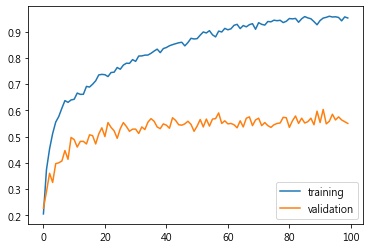

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

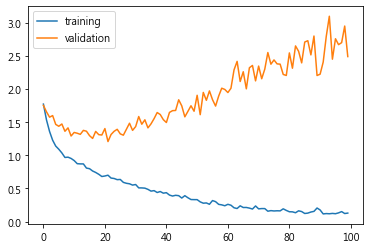

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set(font_scale=1.4)
images_path = './img_ok'
categories = os.listdir(images_path)

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=categories, 
           yticklabels=categories, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
import math
number_of_examples = len(validation_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 128)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(692)):
    test_labels.extend(np.array(validation_data[i][1]))

測試模型

In [7]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
def image_cate_predict(path):
    w = 224
    h = 224
    IMAGE_SIZE = (w, h)
    image = cv2.imdecode(np.fromfile(path.replace('\\','/'),dtype=np.uint8),-1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    image = image.reshape(1,w,h,3)
    re_image = image/255
    model = load_model('wear_cnn_model.h5')
    predictions = model.predict(re_image)
    pred_labels = np.argmax(predictions, axis = 1)
    return pred_labels 
labels = image_cate_predict('./img_ok_1-500/裙子_ok_1-500/nan_裙子_53588006.jpg')
for i ,cat in enumerate(categories):
    print(i,cat)
print(20*'---')
# for idx,cate in enumerate(categories):
#     if labels[0][idx]==1:
#         print(idx,cate)
for i in labels:
    print(i)

0 Dress
1 Outerwear
2 Overalls
3 Pants
4 Skirt
5 Top
------------------------------------------------------------
4
